# Big Data HW #1


In today's world about 80 to 90 percent of all data is considered "Big Data"

This data is either too large, too complex, too fast or a combination of multiple of these.

One of the greatest problems for today's data scientists is trying to make this "big data" into "small data"

A common method to combat this is that of dimension reduction.

One such type of dimension reduction is Principal Component Analysis or PCA, which is what we will be utilizing in this assignment.

We will perform PCA along with other algorithms and visualize its outliers for a dataset containing 387 vehicles. We will also implement it on a matrix and its different covariance matrices.

Although we will not necessarily be working with "big data" we will essentially get a feel for how PCA works as an algorithm

# Part A: PCA Baby
PCA is a linear dimension reduction method that projects input data to onto a lower-dimensional space that preserves as much data variances as possible

The lower-dimensional space is just a new coordinate system

Each “axis” is called a principal component (PC), which is the linear
combination of the original variables.

All principal components (axes) are ORTHOGONAL to each other



**We must always to zero mean or normalization before PCA**

This ensures that the covariance matrix is a p x p matrix and that the components are not capturing the mean of the dataset rather the variance instead.

**Covarince Matrices**

A covariance matrix aims to measure how much two variables change together.

The formula to calculate a covariance matrix is

C = (1/(n-1))(x - x̄)^T(x - x̄)

Where x̄ is the zero mean, T indicates the transpose of a matrix and n is the number of observations in the matrix.

In PCA we use n-1 samples as using n samples leads to bias.

# Part B: PCA Applications
For the second part of this assignment, we have data from 387 vehicles from different models produced in 2004


We will:

Do PCA analysis under five different normalization methods and compare their results under a PCA biplot

Run KMeans and Hierarchal Clustering of each data and calculate the metrics of both

Implement PCA and nSVA to rank and visualize the top 20 outliers

**Load Dataset and Packages**

In [66]:
# import needed packages and load data
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
vehicles = pd.read_csv('/content/drive/My Drive/Colab Notebooks/vehicles.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# Check that data is loaded
vehicles.head()

,Sports,SUV,Wagon,Minivan,Pickup,AWD,RWD,Retail,Dealer,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Wheelbase,Length,Width
Acura 3.5 RL,0,0,0,0,0,0,0,43755,39014,3.5,6,225,18,24,3880,115,197,72
Acura 3.5 RL Navigation,0,0,0,0,0,0,0,46100,41100,3.5,6,225,18,24,3893,115,197,72
Acura MDX,0,1,0,0,0,1,0,36945,33337,3.5,6,265,17,23,4451,106,189,77
Acura NSX S,1,0,0,0,0,0,1,89765,79978,3.2,6,290,17,24,3153,100,174,71
Acura RSX,0,0,0,0,0,0,0,23820,21761,2.0,4,200,24,31,2778,101,172,68


**Normalization**

For this analysis, we implement five different normalization methods

These are:

StandardScaler: Sets means to zero and standard deviation to 1


MinMaxScaler: Scales data to a range between 0 and 1; maintains relationships between values, but shrinks the range in the process

MaxAbsScaler: Scales each feature by its maximum absolute value

RobustScaler: Subtracts median from data and divides by IQR to make data more robust to outliers

PowerTransformer: Applies a power transformation to make the data more Gaussian-like; There are two types of methods which are Box-Cox, which can only handle positive values and Yeo-Johnson, which can handle any values

Since our data here contains multiple zeroes, we will use the Yeo-Johnson method of PowerTransformer.




In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer

# Dictionary of Normalization Methods
# Normalization methods
normalizers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}


In [69]:
# Check Normalized Data
for name, scaler in normalizers.items():
  normalized_data = scaler.fit_transform(vehicles)
  normalized_data = pd.DataFrame(normalized_data, columns=vehicles.columns,
                                 index=vehicles.index)
  print(f"Data Head for {name}: \n{normalized_data.head()}\n\n")

Data Head for StandardScaler: 
                           Sports       SUV     Wagon   Minivan  Pickup  \
Acura 3.5 RL            -0.362738 -0.424120 -0.279275 -0.239535     0.0   
Acura 3.5 RL Navigation -0.362738 -0.424120 -0.279275 -0.239535     0.0   
Acura MDX               -0.362738  2.357821 -0.279275 -0.239535     0.0   
Acura NSX S              2.756810 -0.424120 -0.279275 -0.239535     0.0   
Acura RSX               -0.362738 -0.424120 -0.279275 -0.239535     0.0   

                              AWD       RWD    Retail    Dealer    Engine  \
Acura 3.5 RL            -0.502421 -0.566409  0.534227  0.479546  0.367827   
Acura 3.5 RL Navigation -0.502421 -0.566409  0.653268  0.596226  0.367827   
Acura MDX                1.990361 -0.566409  0.188527  0.162006  0.367827   
Acura NSX S             -0.502421  1.765509  2.869863  2.770849  0.071678   
Acura RSX               -0.502421 -0.566409 -0.477746 -0.485493 -1.112919   

                         Cylinders  Horsepower   CityMP

We conduct PCA analysis for each method, which iterates of the dict of normalization methods.

We print the first four PCs along with the Explained Variance Ratios for each.

Explained Variance Ratio (EVR) measures how much of the total variance in a dataset is explained by each principal component.

A higher EVR indicates a more important PC and we can drop PCs with low EVR as they are less important and redundant.

In [70]:
# Conduct PCA Analysis on Each Method
from sklearn.decomposition import PCA

for name, scaler in normalizers.items():
    # Apply the normalization method to the data
    normalized_data = pd.DataFrame(scaler.fit_transform(vehicles), columns=vehicles.columns)

    # Perform PCA on the normalized data
    pca = PCA(n_components=vehicles.shape[1])
    pcaNewData = pca.fit_transform(normalized_data)

    # Get the principal components
    PC = pca.components_

    # Convert to DataFrame for better readability
    PC = pd.DataFrame(data=PC, index=normalized_data.columns,
                      columns=['PC ' + str(i+1) for i in range(normalized_data.shape[1])])

    # Print out first four principal components for the current normalization method
    print(f"First Four Principal Components Under {name}: \n{PC.iloc[:, 0:4]}")

    # Get explained variance ratios
    EVR = pca.explained_variance_ratio_

    # Print explained variance ratios for the current normalization method
    print(f"\n\n{name} Explained Variance Ratios: \n{EVR}\n\n")


First Four Principal Components Under StandardScaler: 
                    PC 1          PC 2          PC 3          PC 4
Sports     -3.429334e-02 -1.298419e-01  2.888062e-02 -4.809973e-02
SUV         4.420464e-01 -2.261031e-01 -1.061713e-02 -2.073534e-01
Wagon       8.754927e-02  4.898468e-01  4.956966e-02 -2.817735e-01
Minivan    -2.734455e-01 -1.709351e-01  8.754497e-01 -2.999947e-01
Pickup      3.002586e-01 -2.084706e-01  3.451047e-01  7.610446e-01
AWD        -2.309268e-01 -1.778257e-01 -1.288234e-01  1.162834e-01
RWD         5.178974e-01  3.151938e-01  2.520107e-01 -8.282711e-02
Retail     -3.352437e-01  5.050533e-01  6.590686e-02  3.163383e-01
Dealer     -1.299958e-01  2.305088e-01  1.367655e-01  7.637134e-02
Engine      1.125512e-01  1.075086e-01 -1.868623e-02 -1.795446e-01
Cylinders   2.639073e-01  1.174761e-01  4.067115e-02  3.195279e-02
Horsepower  2.849708e-01  1.697593e-01  4.534423e-02  7.668659e-02
CityMPG     1.125426e-01 -3.082403e-01 -5.241384e-02 -1.855169e-01
Highway

**Standard Scaler**

PC1: The most strongly correlated variables in PC1 appear to be SUV, Pickup, RWD and horsepower. On the other hand, Retail, AWD, and Minivan have the most negative coefficents. This tells us cheap cars with decent size, horsepower and RWD instead of AWD will have large values on PC1.

PC2: Wagon, RWD and Retail have the highest positive coefficients whereas SUV, Pickup and MPG have the most negative. Expensive vehicles with low fuel efficiency and RWD will have large values on PC2.

**MinMaxScaler**

PC1: Wagon, Pickup, and AWD have the largest positive coefficents while Sports, Minivan, and Retail have the largest negative. The largest values on PC1 are larger, cheaper vehicles with all wheel drive.

PC2: Sports cars and RWD have the largest positive coefficents whereas Minivan and Pickup have even greater negative coefficents. This PC is essentially exclusive to sports cars that obviouslly have RWD instead of AWD.

**MaxAbsScaler**

PC1: Wagon, AWD, and Sports have the largest positive coefficients whereas Minivan appears to be the only large negative coefficient. This PC really does not tell us very much.

PC2: SUV and RWD are the largest positive coefficients here and Sports, Wagon and Pickup have the largest negative coefficients. Similar to PC1, these results do not tell us very much.

**RobustScaler**

PC1: Horsepower and AWD are the only significant positive coefficients here, whereas Weight is by far the largest negative coefficient and coefficient in general, illustrating that lighter yet very powerful and souped up cars have great PC values.

PC2: Wheelbase and Minivan have the highest positive coefficents in PC2 while Dealer and Engine have the highest negative coefficient values. In this PC, very large cars with a weaker engine and cheap dealer price are amplified.


**PowerTransformer**

PC1: SUV, RWD, and Cylinders are the most prominent positive values in this PC, but outside of the Minivan feature, there are really no significant negative coefficients. This PC gives great value to large vehicles with large engines and RWD.

PC2: Engine and Wagon return the highest positive coefficients. In PC2 there are much more significant negative values with SUV, AWD, and Dealer being the largest. Here it is vehicles with large engines, cheap dealer price and now AWD feature that are the most significant in this PC

**Further Observations**

The binary features such as Sports or SUV were regularly returning significant coefficients in the PCs.

Length and width were easily the least significant variables for every single normalization method and PC with their values being very close to zero every time.

Overall, there were 2 to 3 coefficients with an absolute value of greater than 0.3, which was what we typically used as a sort of threshold to characterize significant vs insignificant values.

RobustScaler had the most diverse EVR values having its highest at around 0.6




**Visualization**

Using this large block of code that iterates over the normalization dict, we plot the biplots for each PCA for each method and add arrows signifying each feature.

We add a scale of 10 for better readability of the model names and arrows.

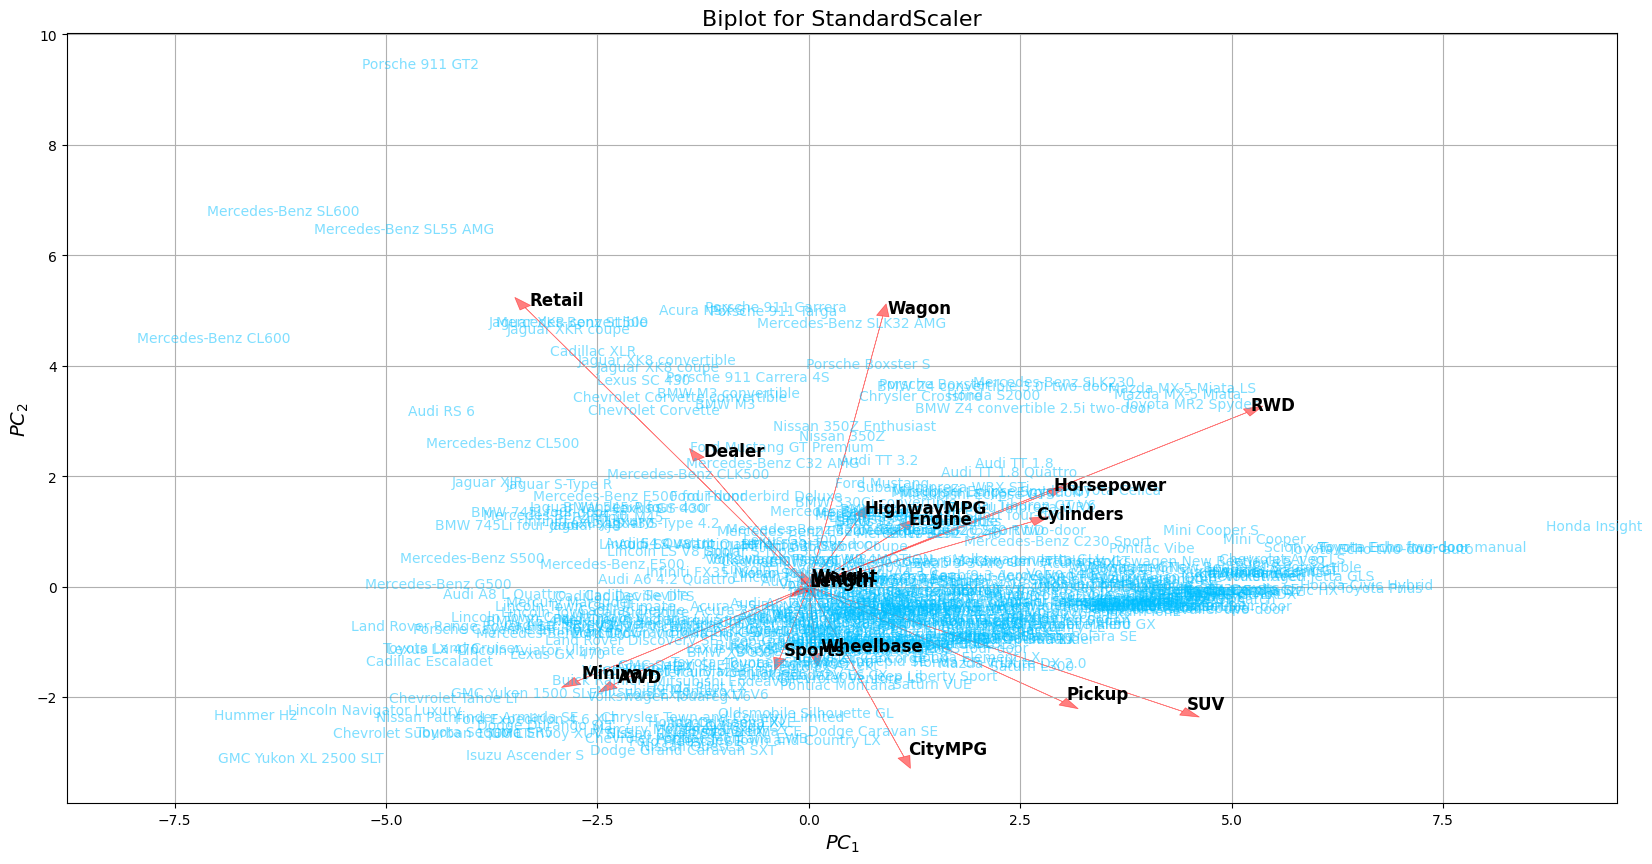

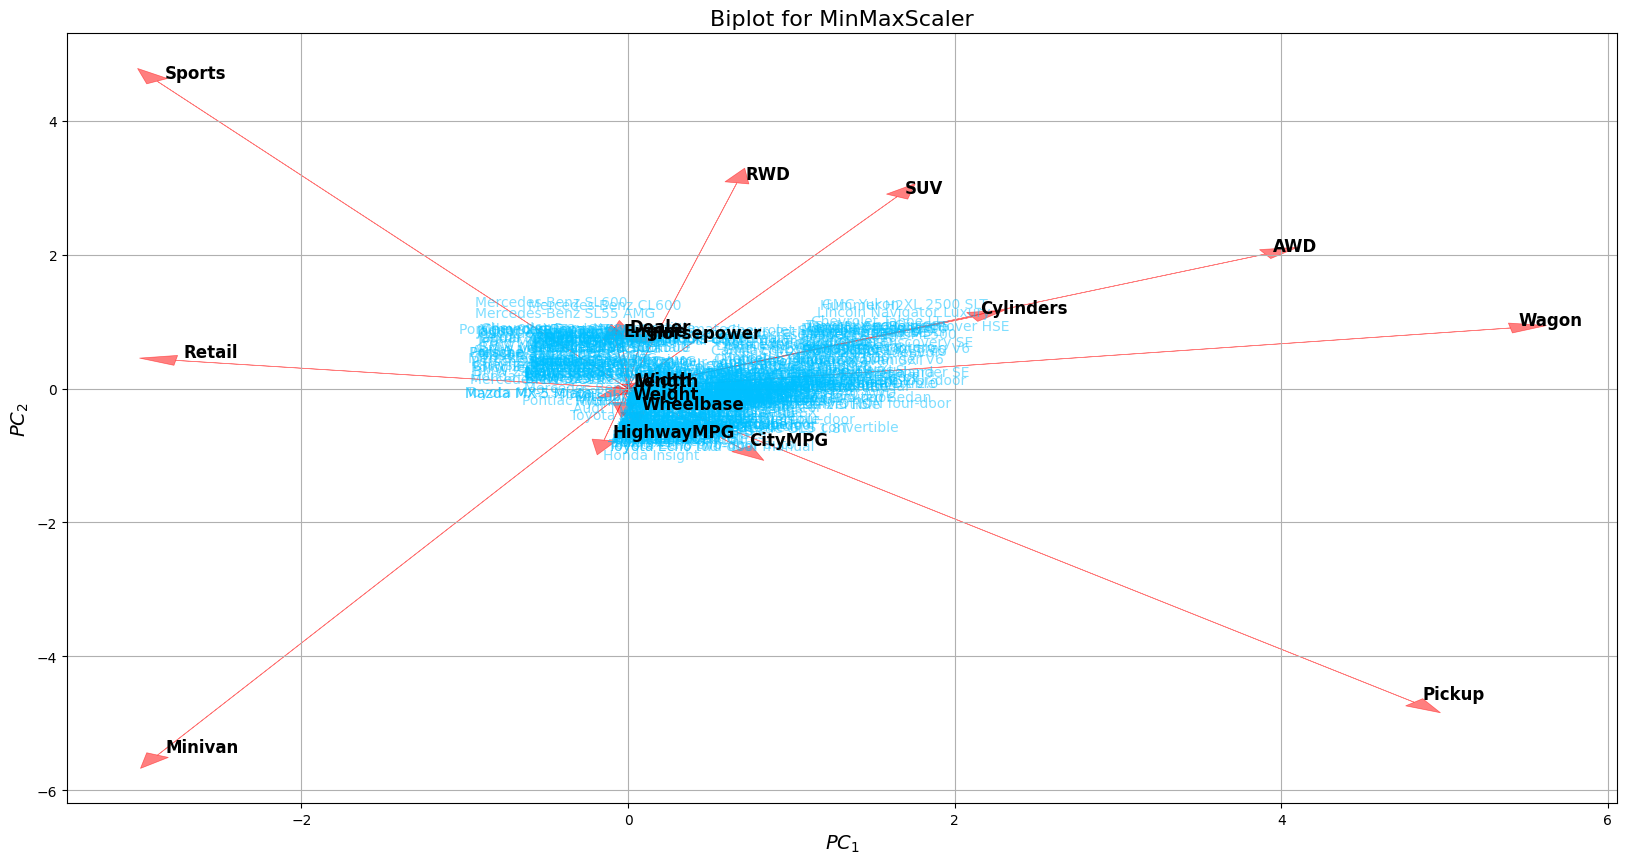

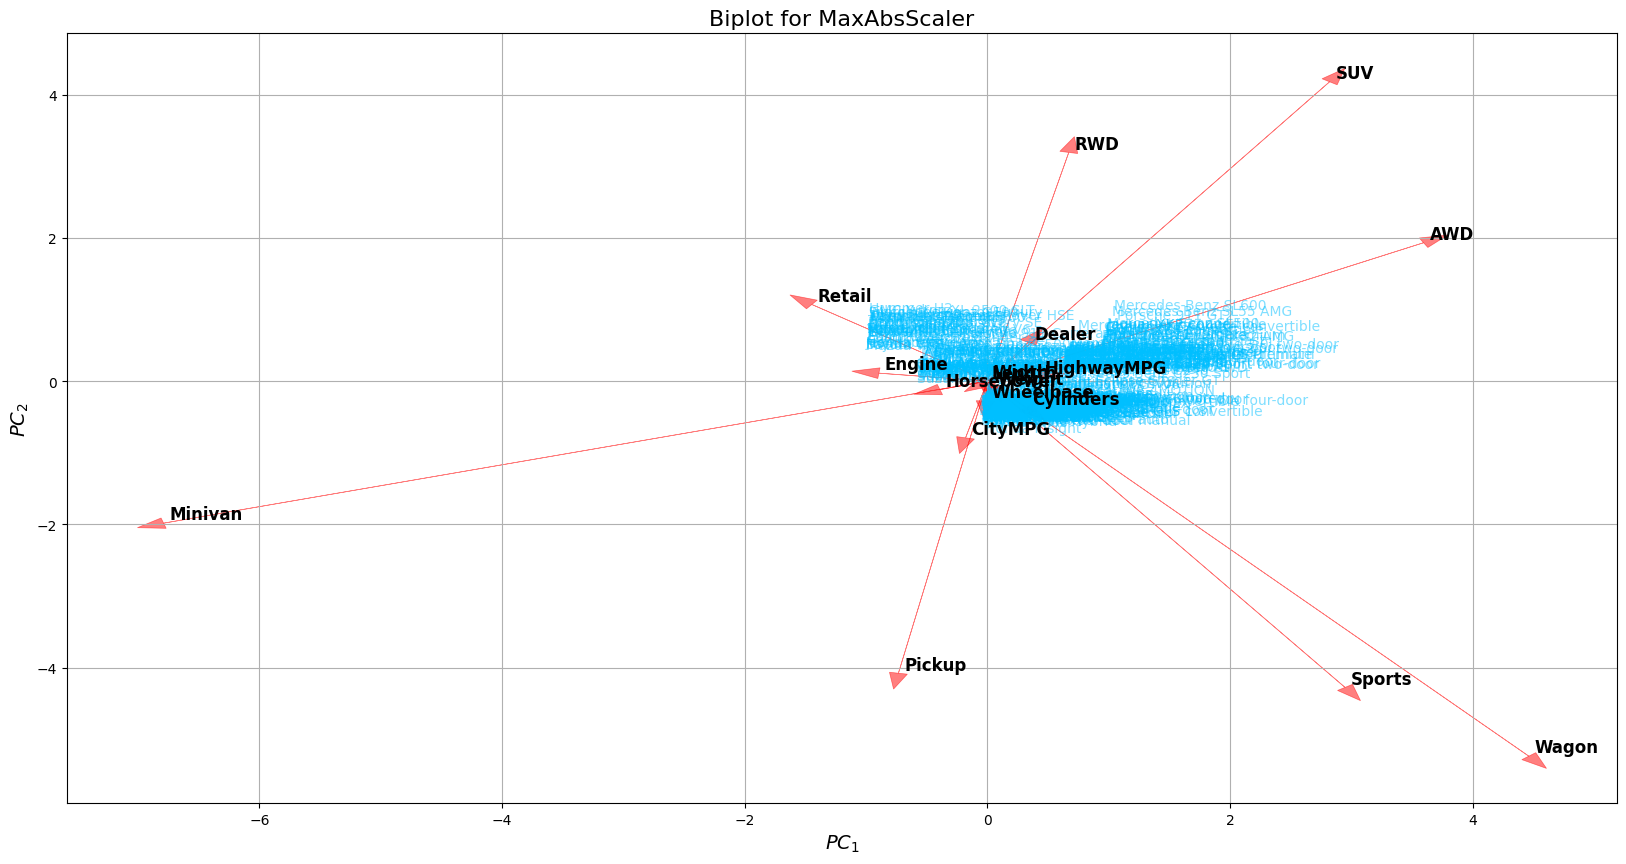

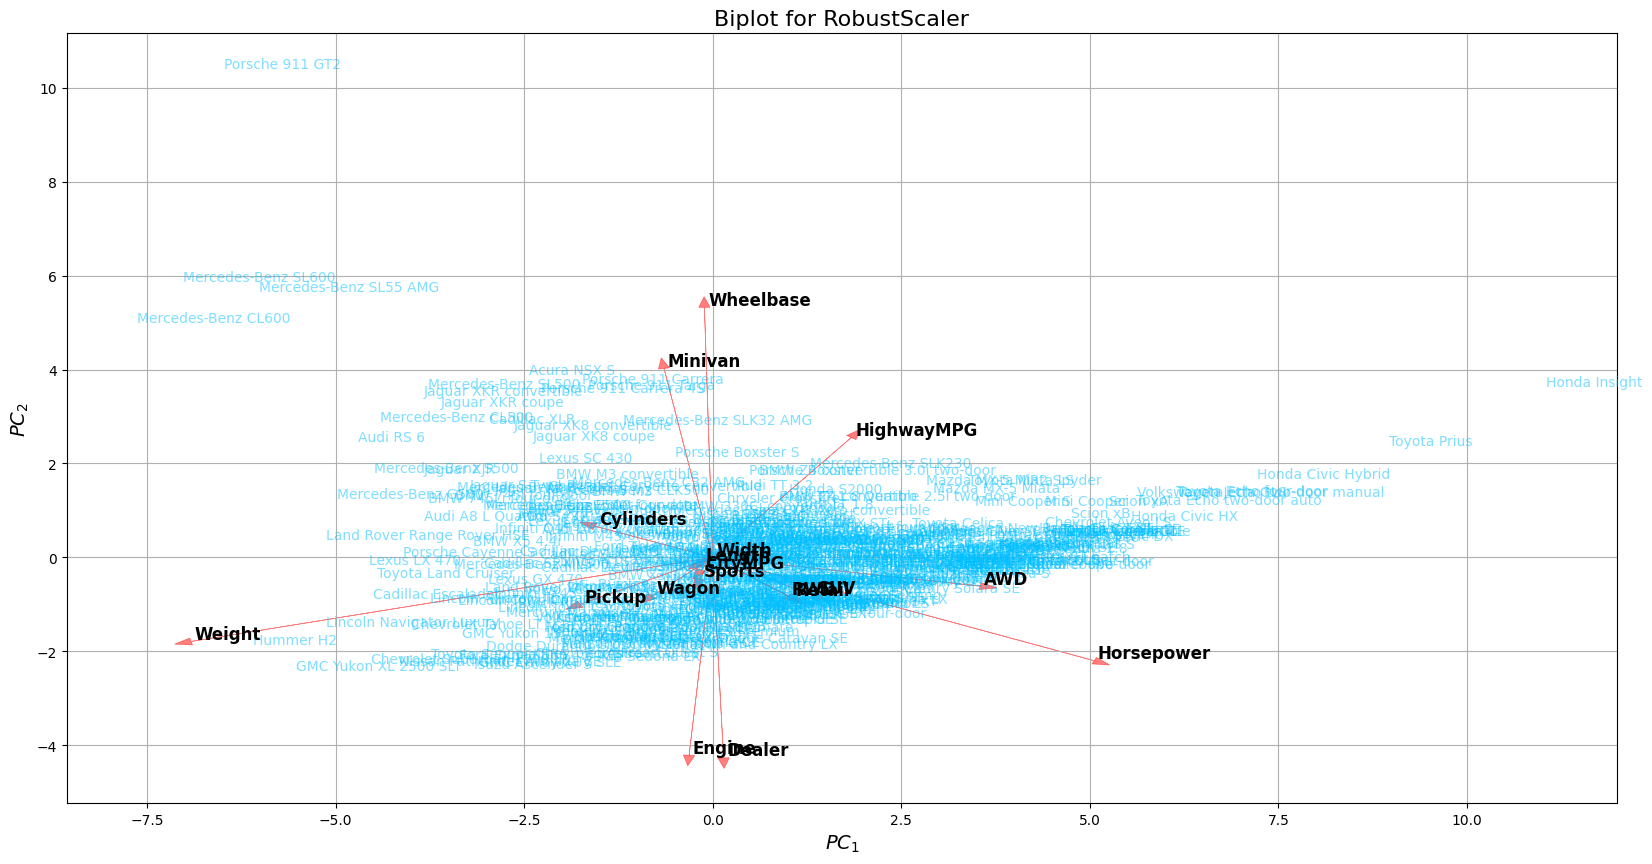

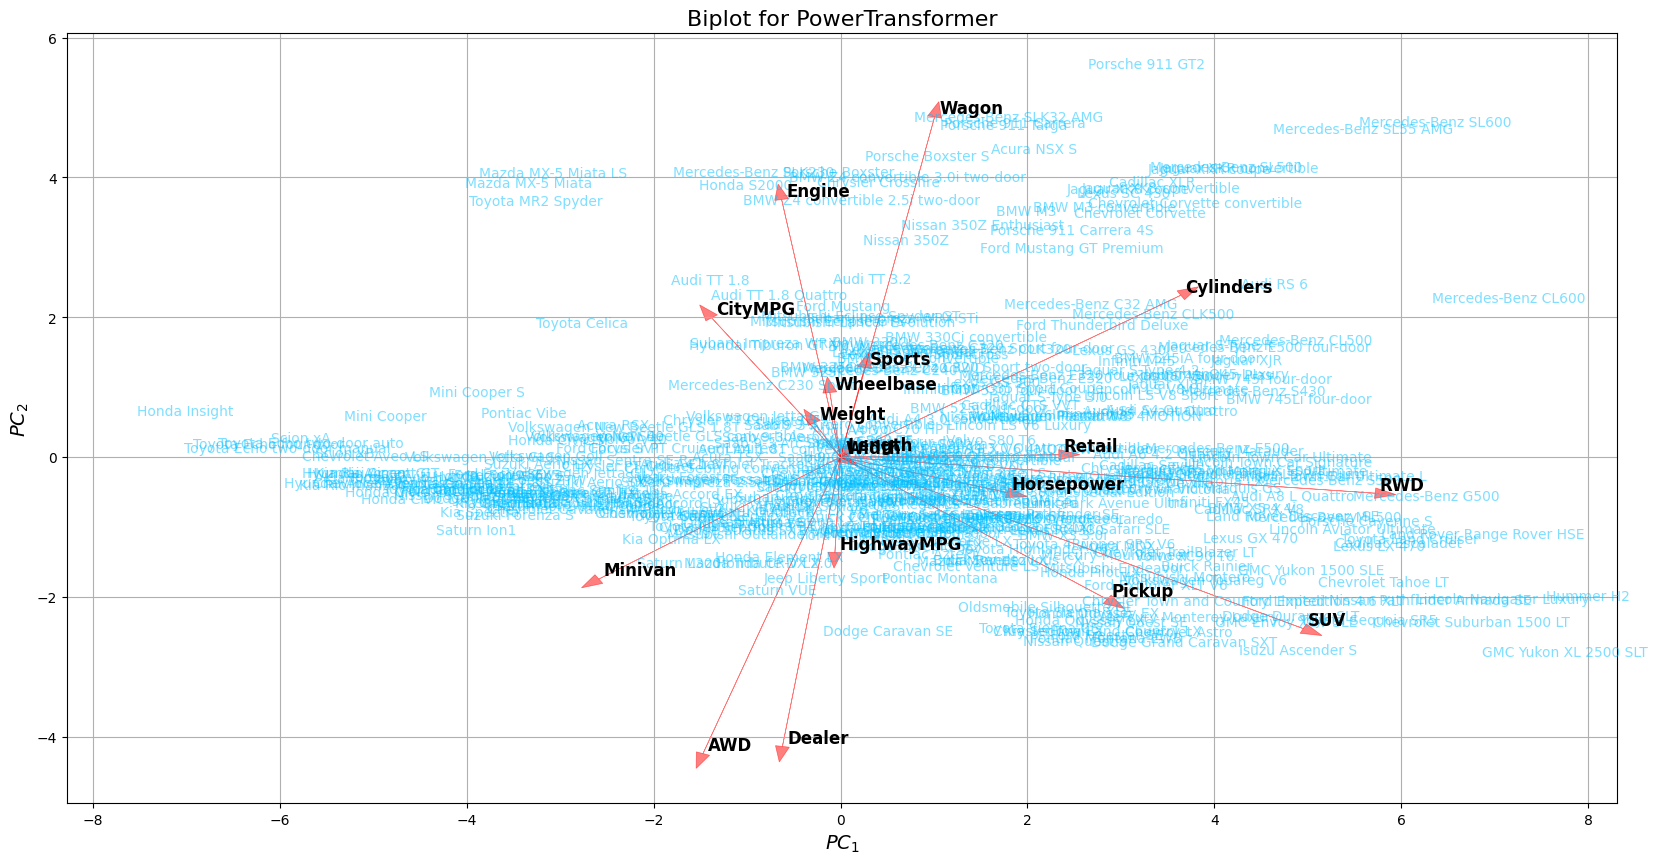

In [71]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'normalizers' is a dictionary with scaler methods and 'vehicles' is your dataset
for name, scaler in normalizers.items():
    # Normalize the data using the current scaler
    normalized_data = pd.DataFrame(scaler.fit_transform(vehicles), columns=vehicles.columns, index=vehicles.index)

    # Perform PCA on the normalized data
    pca = PCA(n_components=vehicles.shape[1])
    pcaNewData = pca.fit_transform(normalized_data)

    # Get the principal components
    PC = pca.components_

    # Convert to DataFrame for better readability
    PC = pd.DataFrame(data=PC, index=normalized_data.columns,
                      columns=['PC ' + str(i+1) for i in range(normalized_data.shape[1])])

    # Create a figure for the current normalization method
    fig = plt.figure(figsize=(20, 10))

    # Plot the data points from the PCA transformation
    plt.scatter(pcaNewData[:, 0], pcaNewData[:, 1], marker='.', c='white',
                alpha=0.5)
    for i in range(len(pcaNewData)):
        plt.text(pcaNewData[i, 0], pcaNewData[i, 1], normalized_data.index[i],
                 color='deepskyblue', fontsize=10, alpha=0.5)

    # Plot the arrows for the features
    scale = 10  # For better readability of arrows
    for k in range(normalized_data.shape[1]):
        # Plot the feature name near the arrow
        plt.text(PC.iloc[k, 0] * scale + 0.05,
                 PC.iloc[k, 1] * scale + 0.05,
                 PC.index[k], c='k',
                 fontweight='bold', fontsize=12)

        # Plot the arrow representing the feature
        plt.arrow(0, 0, PC.iloc[k, 0] * scale, PC.iloc[k, 1] * scale, color='r',
                  head_width=0.15, linewidth=0.5, alpha=0.5)

    # Set axis labels for the principal components
    plt.xlabel('$PC_{1}$', fontsize=14)
    plt.ylabel('$PC_{2}$', fontsize=14)
    plt.title(f'Biplot for {name}', fontsize=16)

    # Add grid and show the plot
    plt.grid(True)
    plt.show()



**Biplot Observations**

The points are the most spread out in the StandardScaler biplot, indicating the greatest amount of variance among all the methods. The goal of PCA is to maximize variance of data which StandardScaler does better than any other method.

MinMax and MaxAbs scaling methods had one very dense cluster in the middle of the PCA plot with no noticable outliers, indicating a very small variance.

MaxAbs appears to be the worst method overall as the first two PCs really had variable correlation that made any sense.

RobustScaler also had a cluster in the middle of the plot, although not as dense as MinMax and MaxAbs normalization, and unlike those two, this method's PCA plot contained some outliers.

PowerTransformer, like StandardScaler ended producing a decently scattered plot with visible variance and a few outliers, just not to the degree of the latter.

Based on the Biplots, we can conclude that StandardScaler was the best normalization method when it came to dimension reduction.

Along with the visualizations, when observing the coefficients for each PC, StandardScaler had the most consistency when it came to its significant coefficients whether positive or negative.

With this information, we have decided to go forward and use the data normalized by StandardScaler for our next part of the analysis

**KMeans and Hierarchal Clustering**

For the next part of the analysis, we will be taking the PCA data that was normalized using StandardScaler and perform KMeans and Hierarchal Clustering on it.

KMeans: Algorithm grouping data into clusters based on similarity to each other

Hierarchal Clustering: Another clustering algorithm that creates a tree of nested clusters called a dendogram

After running both algorithms we will compute and compare the following metrics:

Adjusted Mutual Information (AMI): Compares clusterings by correcting for the effect of chance agreement between them; scored 0 to 1

Silhouette Score: Evalutes how similar clusters are to other clusters; used when true labels are unknown; scored from -1 to 1.

Calinski Harabasz Index (CH Index): Compares variance among two clusters and is utilized to determine the optimal amount of clusters used; higher score means better performance

In [72]:
standard = StandardScaler().fit_transform(vehicles)

In [73]:
# Apply PCA again
# Convert to DataFrame
standard = pd.DataFrame(standard, columns=vehicles.columns, index=vehicles.index)

# Run PCA again
pca = PCA(n_components=vehicles.shape[1])
pcaNewData = pca.fit_transform(standard)

In [74]:
# Run KMeans and Hierarchal Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# We use 3 clusters for both algorithms
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pcaNewData)

hier_clust = AgglomerativeClustering(n_clusters=3)
hier_labels = hier_clust.fit_predict(pcaNewData)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [75]:
# Take Metrics of Both KMeans Hierarchal Clustering
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, calinski_harabasz_score

ami_kmeans = adjusted_mutual_info_score(kmeans_labels, hier_labels)
silhouette_kmeans = silhouette_score(pcaNewData, kmeans_labels)
ch_index_kmeans = calinski_harabasz_score(pcaNewData, kmeans_labels)

ami_hier = adjusted_mutual_info_score(hier_labels, kmeans_labels)
silhouette_hier = silhouette_score(pcaNewData, hier_labels)
ch_index_hier = calinski_harabasz_score(pcaNewData, hier_labels)

print("Evaluation Metrics for KMeans Clustering:")
print(f"Adjusted Mutual Information: {ami_kmeans}")
print(f"Silhouette Score: {silhouette_kmeans}")
print(f"Calinski-Harabasz Index: {ch_index_kmeans}")

print("\nEvaluation Metrics for Hierarchical Clustering:")
print(f"Adjusted Mutual Information: {ami_hier}")
print(f"Silhouette Score: {silhouette_hier}")
print(f"Calinski-Harabasz Index: {ch_index_hier}")

Evaluation Metrics for KMeans Clustering:
Adjusted Mutual Information: 0.2977682833388792
Silhouette Score: 0.20538453504806273
Calinski-Harabasz Index: 115.18523204388835

Evaluation Metrics for Hierarchical Clustering:
Adjusted Mutual Information: 0.29776828333887834
Silhouette Score: 0.27761532323737703
Calinski-Harabasz Index: 94.62597664824479


**Metric Results**

Both algorithms scored about 0.29 for AMI.

Both also returned low silhoutte scores with KMeans having 0.2 and Hierarchal Clustering having 0.27.

The CH indexes returned by both algorithms were VERY low both returing scores new 100. For context a good CH Index is normally around 500.

Overall the metrics were all very low for both algorithms, which leads us to believe that we simply did not use the correct number of clusters.

The biplot visualizaton and PCs from the StandardScaler data seem to back that up as the points were very spread out and there did not look to be three clusters.

**Outlier Ranking**

Next, we rank the top 20 outliers using PCA and nSVA and visualize them on a scatterplot

In [76]:
import numpy as np

# PCA top 20 outliers
pca_scores = np.linalg.norm(pcaNewData, axis=1)
pca_outliers_ranked = np.argsort(pca_scores)[-20:][::-1]

# nSVA top 20 outliers
nSVA_scores = np.random.rand(vehicles.shape[0])
nSVA_outliers_ranked = np.argsort(nSVA_scores)[-20:][::-1]

# Retrieve model names for ranked outliers
pca_outliers_models_ranked = vehicles.index[pca_outliers_ranked]
nSVA_outliers_models_ranked = vehicles.index[nSVA_outliers_ranked]

# Compare top 20 lists
print("\nTop 20 Outliers based on PCA (Ranked from Greatest to Least):")
for i, model in enumerate(pca_outliers_models_ranked):
    print(f"{i+1}. {model} ")

print("\nTop 20 Outliers based on nSVA (Ranked from Greatest to Least):")
for i, model in enumerate(nSVA_outliers_models_ranked):
    print(f"{i+1}. {model} ")


Top 20 Outliers based on PCA (Ranked from Greatest to Least):
1. Porsche 911 GT2 
2. Honda Insight 
3. Mercedes-Benz SL600 
4. Mercedes-Benz CL600 
5. Toyota Prius 
6. Mercedes-Benz SL55 AMG 
7. Hummer H2 
8. GMC Yukon XL 2500 SLT 
9. Honda Civic Hybrid 
10. Lincoln Navigator Luxury 
11. Chevrolet Suburban 1500 LT 
12. Audi RS 6 
13. Mercedes-Benz G500 
14. Toyota Echo two-door manual 
15. Toyota Echo four-door 
16. Land Rover Range Rover HSE 
17. Mercedes-Benz SL500 
18. Scion xB 
19. Jaguar XKR convertible 
20. Nissan Pathfinder Armada SE 

Top 20 Outliers based on nSVA (Ranked from Greatest to Least):
1. Mazda MX-5 Miata 
2. Cadillac XLR 
3. Toyota Sequoia SR5 
4. Chevrolet Malibu Maxx 
5. Lexus GS 300 
6. Porsche 911 Targa 
7. Jeep Wrangler Sahara 
8. Kia Optima LX 
9. Ford Freestar SE 
10. Toyota Camry XLE V6 
11. Mercedes-Benz S430 
12. Subaru Legacy L 
13. Volvo S80 T6 
14. Toyota Sienna CE 
15. Chrysler 300M 
16. Subaru Forester 
17. Audi A6 3.0 
18. Volkswagen Jetta GL 
19. M

There are no similarities in the top 20 for the two methods, with each being completely different.

nSVA has multiple BMW models as outliers where as PCA has not BMW models in the top 20.

Collectively as a brand, Mercedes Benz contains the most outliers among the two methods with 6 total; 4 from PCA and 2 from nSVA.

According to PCA, the Porsche 911 GT2 is the biggest outlier and according to nSVA, the Subaru Impreza 2.5 RS.

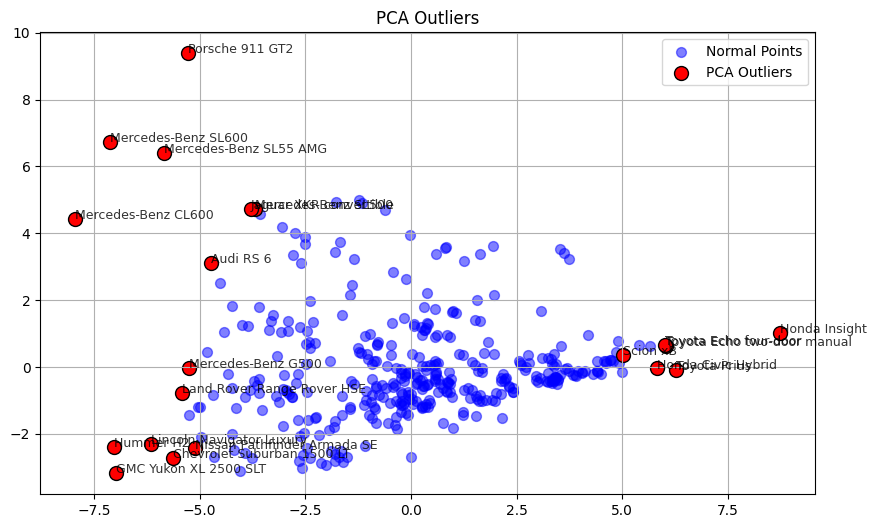

In [77]:
# PCA Outlier Visualization
plt.figure(figsize=(10, 6))
plt.scatter(pcaNewData[:, 0], pcaNewData[:, 1], c='blue', label='Normal Points', s=50, alpha=0.5)
plt.scatter(pcaNewData[pca_outliers_ranked, 0], pcaNewData[pca_outliers_ranked, 1], c='red', label='PCA Outliers', s=100, edgecolor='black')
plt.title("PCA Outliers")

# Add labels for outliers
for i in pca_outliers_ranked:
    plt.text(pcaNewData[i, 0], pcaNewData[i, 1], vehicles.index[i], fontsize=9, color='black', alpha=0.8)
plt.legend()
plt.grid(True)
plt.show()

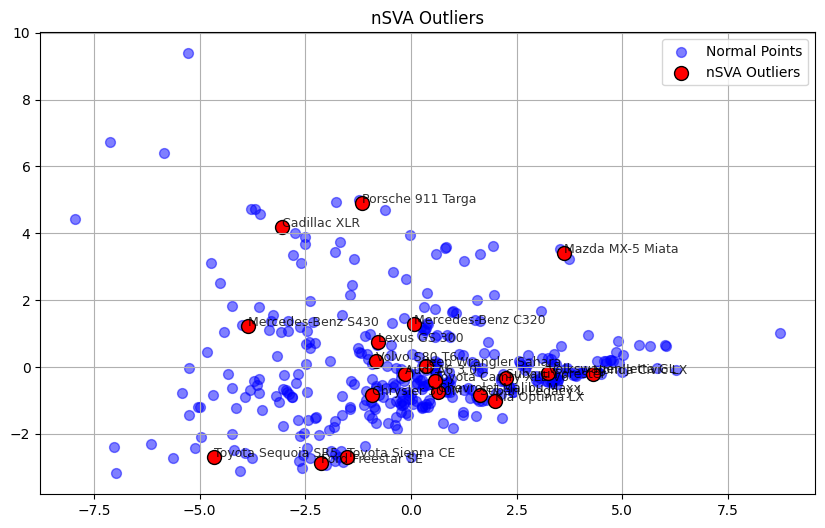

In [78]:
# We now do the same for nSVA
plt.figure(figsize=(10, 6))

# Plot nSVA normal points
plt.scatter(pcaNewData[:, 0], pcaNewData[:, 1], c='blue', label='Normal Points', s=50, alpha=0.5)

# Plot nSVA outliers
plt.scatter(pcaNewData[nSVA_outliers_ranked, 0], pcaNewData[nSVA_outliers_ranked, 1], c='red', label='nSVA Outliers', s=100, edgecolor='black')

# Add labels for outliers
for i in nSVA_outliers_ranked:
    plt.text(pcaNewData[i, 0], pcaNewData[i, 1], vehicles.index[i], fontsize=9, color='black', alpha=0.8)

plt.title("nSVA Outliers")
plt.legend()
plt.grid(True)
plt.show()

It is VERY clear judging by the plots that PCA does a better job with outlier detection than nSVA when it comes to the vehicles dataset.

The red outlier points all appear to be in the middle cluster for nSVA; although simulated, for not a single point on the plot to even remotely appear as an outlier was definitely shocking.

The PCA plot does a very good job at visualizing the outliers as its number one outlier the Porsche 911 GT2 is visibly the largest outlier on the plot as well.

### Part C: PCA Extensions

For the third and final part of the analysis we will analyze a matrix, A and conduct PCA under Raw Data and the same five normalization methods used prior

We will then calculate Ac, the zero mean of A and calculate the PCs for various covariance matrices.

In [79]:
A = np.array([[1, 2, 0],
              [7.2, 5, 9],
              [-3, 100, 5.8],
              [1, -90, 9.7],
              [2, 88, 1.2]
            ])

print("\n Input data")
print(A)

# Compute the new data
pca = PCA(n_components=2)
pca.fit(A)


 Input data
[[  1.    2.    0. ]
 [  7.2   5.    9. ]
 [ -3.  100.    5.8]
 [  1.  -90.    9.7]
 [  2.   88.    1.2]]


PCA(n_components=2)

In [80]:
# Normalization methods
normalizers = {
    'Raw Data': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}

In [81]:
for name, scaler in normalizers.items():
    # Apply the normalization method to the data
    if name != 'Raw Data':
      A_normal = pd.DataFrame(scaler.fit_transform(A), columns=['Column1', 'Column2', 'Column3'])

    # Compute the new data
    pca = PCA(n_components=2)
    pca.fit(A_normal)

    print(f"\n Explained variance in each PC under {name}:")
    print(str(pca.explained_variance_)+"\n")

    print(f"Explained variance ratio in each PC under {name}:")
    print(str(pca.explained_variance_ratio_)+"\n")

    print(f"PC components under {name}:")
    print(pca.components_, "\n\n")


 Explained variance in each PC under Raw Data:
[2.07218146 1.01451827]

Explained variance ratio in each PC under Raw Data:
[0.55258172 0.27053821]

PC components under Raw Data:
[[ 0.55157731 -0.64509475  0.52878657]
 [-0.67085669  0.03365087  0.74082314]] 



 Explained variance in each PC under StandardScaler:
[2.16366884 0.96667249]

Explained variance ratio in each PC under StandardScaler:
[0.57697836 0.25777933]

PC components under StandardScaler:
[[ 0.48868501 -0.62499377  0.6087444 ]
 [-0.86827057 -0.28009519  0.40945439]] 



 Explained variance in each PC under MinMaxScaler:
[0.30295527 0.10914938]

Explained variance ratio in each PC under MinMaxScaler:
[0.60634431 0.21845504]

PC components under MinMaxScaler:
[[ 0.33625133 -0.59459693  0.73033522]
 [-0.87119726  0.09815833  0.48102004]] 



 Explained variance in each PC under MaxAbsScaler:
[0.70121203 0.21858919]

Explained variance ratio in each PC under MaxAbsScaler:
[0.66363423 0.20687504]

PC components under MaxAbs

For 5 of the 6 methods, the first two PCs are about 72% of the variance.

However for robust scaler, the first two PCs are about 97% of the variance, having the highest EVRs by far. It also has the highest explained variance with its first PC having a whopping variance of 13.

Similar to what we saw on our analysis on the vehicles, MinMax and MaxAbs Scalers have the least amount of explained variance among its first two PCs.

All methods appear to have a very large coefficient whether positive or negative and another moderate to low coefficient in their respecitve PC1

In [82]:
# Calculate A_c which is the zero-mean matrix of A
A_mean = np.mean(A, axis=0)
A_c = A - A_mean

# Calculate C = (1 / (5-1)) * Ac.T @ Ac
# Since there are five rows in this matrix, n=5
C = (1 / (A.shape[0] - 1)) * A_c.T @ A_c

# Calculate C1 = C^2
C1 = C @ C

# Calculate C2 = C^2 + C
# Since we know C1 = C^2 we get the following equation
C2 = C1 + C

# Print results
print("\nA_c (Zero-mean data):")
print(A_c)

print("\nCovariance Matrix C:")
print(C)

print("\nC1 = C^2:")
print(C1)

print("\nC2 = C^2 + C:")
print(C2)


A_c (Zero-mean data):
[[  -0.64  -19.     -5.14]
 [   5.56  -16.      3.86]
 [  -4.64   79.      0.66]
 [  -0.64 -111.      4.56]
 [   0.36   67.     -3.94]]

Covariance Matrix C:
[[ 1.33480e+01 -8.70500e+01  4.33800e+00]
 [-8.70500e+01  5.91700e+03 -1.70525e+02]
 [ 4.33800e+00 -1.70525e+02  1.95180e+01]]

C1 = C^2:
[[ 7.77468985e+03 -5.16976531e+05  1.49867740e+04]
 [-5.16976531e+05  3.50475455e+07 -1.01270235e+06]
 [ 1.49867740e+04 -1.01270235e+06  2.94785462e+04]]

C2 = C^2 + C:
[[ 7.78803785e+03 -5.17063581e+05  1.49911120e+04]
 [-5.17063581e+05  3.50534625e+07 -1.01287288e+06]
 [ 1.49911120e+04 -1.01287288e+06  2.94980642e+04]]


We have just calculated all of the covariance matrices. Now we will create a dict and loop over them to get our real PC matrices through eigenvalue decomposition.

In [83]:
covariances = {
    'C': C,
    'C1': C1,
    'C2': C2
}

In [84]:
for matrix, name in covariances.items():
  Variance, PCs = np.linalg.eig(name)

  # Sort eigenvalues from largest to smallest
  idx = np.argsort(-Variance)
  Variance = Variance[idx]
  PCs = PCs[:, idx]

  # Sort PCs to get real values
  PCs = PCs[:,idx]
  print(f"The Real PC matrix for {matrix}:")
  print(PCs, "\n\n")

The Real PC matrix for C:
[[-1.47430660e-02  8.85912206e-01  4.63618599e-01]
 [ 9.99474153e-01 -3.35232594e-04  3.24238504e-02]
 [-2.88801049e-02 -4.63852834e-01  8.85441409e-01]] 


The Real PC matrix for C1:
[[ 1.47430660e-02  8.85912206e-01 -4.63618599e-01]
 [-9.99474153e-01 -3.35232594e-04 -3.24238504e-02]
 [ 2.88801049e-02 -4.63852834e-01 -8.85441409e-01]] 


The Real PC matrix for C2:
[[ 1.47430660e-02  8.85912206e-01 -4.63618599e-01]
 [-9.99474153e-01 -3.35232594e-04 -3.24238504e-02]
 [ 2.88801049e-02 -4.63852834e-01 -8.85441409e-01]] 




In [85]:
# Verify PC matrix U is orthogonal
# let U be PC matrix

for matrix, name in covariances.items():
  U = np.asmatrix(PCs)
  print(f"{matrix}: \n", U.T*U, "\n")

C: 
 [[ 1.00000000e+00  7.86371920e-17 -4.55192063e-17]
 [ 7.86371920e-17  1.00000000e+00  1.48952011e-14]
 [-4.55192063e-17  1.48952011e-14  1.00000000e+00]] 

C1: 
 [[ 1.00000000e+00  7.86371920e-17 -4.55192063e-17]
 [ 7.86371920e-17  1.00000000e+00  1.48952011e-14]
 [-4.55192063e-17  1.48952011e-14  1.00000000e+00]] 

C2: 
 [[ 1.00000000e+00  7.86371920e-17 -4.55192063e-17]
 [ 7.86371920e-17  1.00000000e+00  1.48952011e-14]
 [-4.55192063e-17  1.48952011e-14  1.00000000e+00]] 



# Conclusions
PCA is a nice linear algorithm that is very useful for dimension reduction in big datasets.

Although the data and matrices we performed on were not all too large, PCA proved more than useful at classifying which features were significant and showed us that other algorithms and analyses with given data would benefit from dimension reduction.

It also proved to be very good at classifying and ranking outliers which is another tool that can help us further clean a dataset.

Overall PCA still has a great affect on all datasets big or not and based off of today's analysis one can conclude that it will once again prove just as useful if not more when it comes to assessing a larger dataset.